In [72]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import geopandas as gpd

In [74]:
df = pd.read_csv('Dataset/Crime_Dataset_Coursework1.csv', low_memory=False)
county_map = gpd.read_file("GeoJSON/Montgomery.geo.json")
print('Dataframe and GeoJSON files Imported')

Dataframe Imported


In [75]:
#Custom dataframe to be used for certain visualisations
df_D =df.copy()
print('Dataframe copied to df_D')

Dataframe copied to df_D


In [76]:
def cleanup(df):
    #Remove unused columns
    df = df.drop(['Offence Code', 'CR Number', 'Victims', 'Crime Name3', 'Block Address', 'State', 'Zip Code', 'Agency', 'Sector', 'Beat', 'PRA', 'Address Number', 'Street Prefix', 'Street Type', 'Street Suffix', 'End_Date_Time', 'Police District Number', 'Location'], axis=1)
    df['Place'] = df['Place'].str.split('-').str[0] # Used to simplify the Place column
    #df = df[df['City'].str.match(r'^[a-zA-Z]+$')] # Used to remove the City column with any other value than characters
    df_1 = df[df['City'] != '0']  # Filter the dataset by removing rows where `City` is '0'
    return df_1

In [77]:
def dfsize(df1, df2):
        
    memory_usage_df1 = df1.memory_usage(deep=True).sum()
    memory_usage_df2 = df2.memory_usage(deep=True).sum()

    difference_bytes = memory_usage_df1 - memory_usage_df2
    difference_percent = (difference_bytes / memory_usage_df1) * 100

    print(f"Memory usage of DataFrame 1: {memory_usage_df1} bytes")
    print(f"Memory usage of DataFrame 2: {memory_usage_df2} bytes")
    print(f"Difference: {difference_bytes} bytes")
    print(f"Percentage difference: {difference_percent:.2f}%")



In [81]:
df_D = cleanup(df_D)
dfsize(df, df_D)

Memory usage of DataFrame 1: 418216123 bytes
Memory usage of DataFrame 2: 182054522 bytes
Difference: 236161601 bytes
Percentage difference: 56.47%


In [108]:
def response_time(df):
    # Convert columns to datetime objects
    df['Start_Date_Time'] = pd.to_datetime(df['Start_Date_Time'])
    df['Dispatch Date / Time'] = pd.to_datetime(df['Dispatch Date / Time'])

    # Calculate the time difference in seconds
    time_diff_seconds = (df['Start_Date_Time'] - df['Dispatch Date / Time']).dt.total_seconds().abs()
    df['Response_time'] = time_diff_seconds
    
    # Convert seconds to days
    time_diff_days = time_diff_seconds / (24 * 60 * 60)

    # Add a new column to the DataFrame
    df['Response_time_days'] = time_diff_days
    print('Response time calculated')
    
    return df

In [110]:
df_D = response_time(df_D)

Response time calculated


Question 1: The top police districts with the lowest response time.

Visualisation 1

In [131]:
#Using the mean function to find the Police districts with the lease response time 
top_districts = df_D.groupby('Police District Name')['Response_time_days'].mean().nsmallest(5).reset_index()

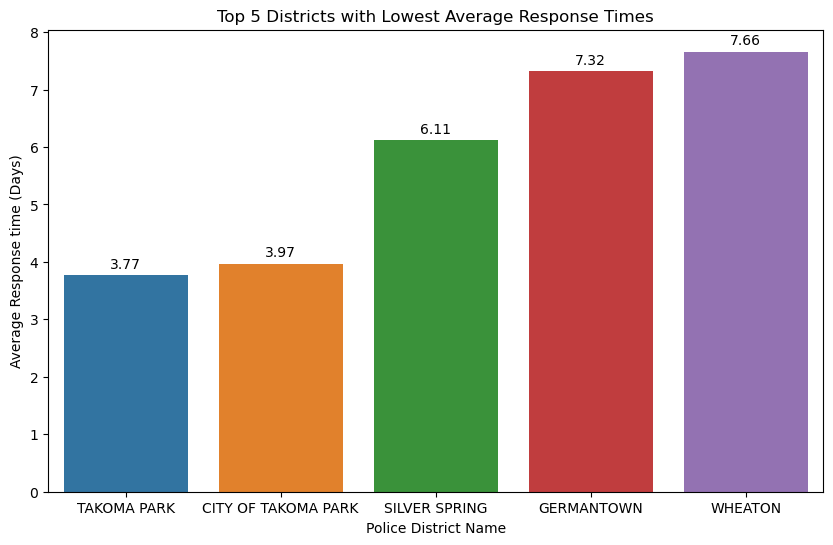

In [133]:
# Create a bar plot using the `top_3_districts` DataFrame
plt.figure(figsize=(10, 6))
ax = sns.barplot(y=top_districts['Response_time_days'], x= top_districts['Police District Name'], data=top_districts, hue='Police District Name')
plt.xlabel('Police District Names')
plt.ylabel('Mean Response Time (Minutes)')
# Add a title and labels for the x-axis and y-axis
plt.title('Top 5 Districts with Lowest Average Response Times')
plt.xlabel('Police District Name')
plt.ylabel('Average Response time (Days)')

# Add value labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline',
                fontsize=10, color='black', 
                xytext=(0, 5), 
                textcoords='offset points')
    
# Display the plot
plt.show()

#Visualisation 2

In [151]:
def nibrs_mapping(df):
    
    nibrs_mapping = {
    '220': 'A',
    '13A': 'A',
    '13B': 'A',
    '13C': 'A',
    '510': 'A',
    '250': 'A',
    '290': 'A',
    '35A': 'A',
    '35B': 'A',
    '270': 'A',
    '210': 'A',
    '26A': 'A',
    '26B': 'A',
    '26C': 'A',
    '26D': 'A',
    '26E': 'A',
    '39A': 'A',
    '39B': 'A',
    '39C': 'A',
    '39D': 'A',
    '09A': 'A',
    '09B': 'A',
    '09C': 'A',
    '100': 'A',
    '23A': 'A',
    '23B': 'A',
    '23C': 'A',
    '23D': 'A',
    '23E': 'A',
    '23F': 'A',
    '23G': 'A',
    '23H': 'A',
    '240': 'A',
    '370': 'A',
    '40A': 'A',
    '40B': 'A',
    '120': 'A',
    '11A': 'A',
    '11B': 'A',
    '11C': 'A',
    '11D': 'A',
    '280': 'A',
    '520': 'A',
    '90A': 'B',
    '90B': 'B',
    '90C': 'B',
    '90D': 'B',
    '90E': 'B',
    '90F': 'B',
    '90G': 'B',
    '90H': 'B',
    '90I': 'B',
    '90J': 'B',
    '90Z': 'B'
    }

    # Convert the dictionary to a DataFrame
    lookup_df = pd.DataFrame(list(nibrs_mapping.items()), columns=['NIBRS Code', 'Crime Type'])
    df = pd.merge(df, lookup_df, on='NIBRS Code', how='left')
    print('NIBRS Mapping done')
    return df

In [153]:
def aggregate(df):
    df_D_filtered = df[df['Police District Name'].isin(['TAKOMA PARK', 'CITY OF TAKOMA PARK', 'SILVER SPRING', 'GERMANTOWN', 'WHEATON'])]
    # Aggregate the filtered DataFrame by `Police District Name` and `Crime Type` and compute the mean of `Response_time_sec`
    df_D_agg = df_D_filtered.groupby(['Police District Name', 'Crime Type'])['Response_time_days'].mean().sort_values().reset_index()
    # Add `Response_time_min` column to the aggregated DataFrame by dividing `Response_time_sec` by 60
    return df_D_agg

In [155]:
df_D = nibrs_mapping(df_D)
df_D_agg = aggregate(df_D)

NIBRS Mapping done


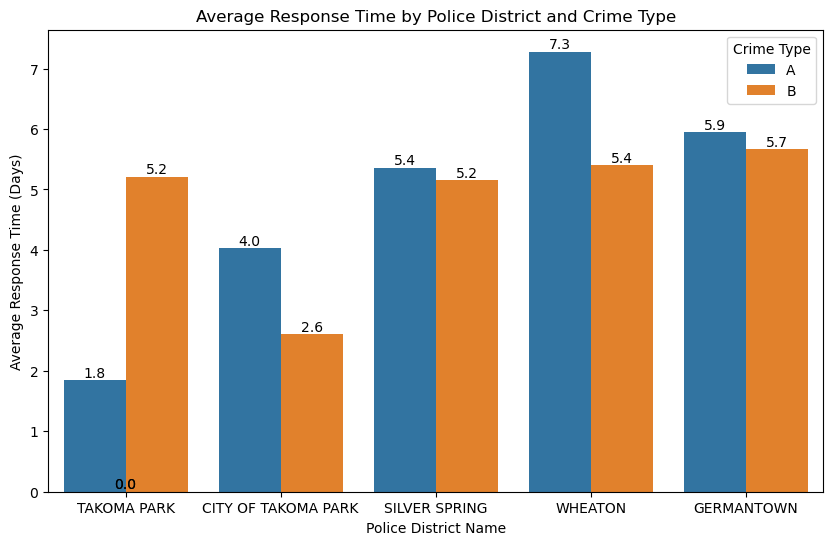

In [165]:
# Create the stacked bar chart using seaborn
plt.figure(figsize=(10, 6))

# Plot stacked bars
ax = sns.barplot(x='Police District Name', y='Response_time_days', hue='Crime Type', data=df_D_agg)

# Add data labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

# Add a title and labels for the x-axis and y-axis
plt.title('Average Response Time by Police District and Crime Type')
plt.xlabel('Police District Name')
plt.ylabel('Average Response Time (Days)')

# Display the plot
plt.show()

Question 2: How does the location (based on the city) of the crime impact the response time?

Visualisation 1

In [182]:
avg_response_times = df_D.groupby('City')['Response_time_days'].mean().sort_values().reset_index()

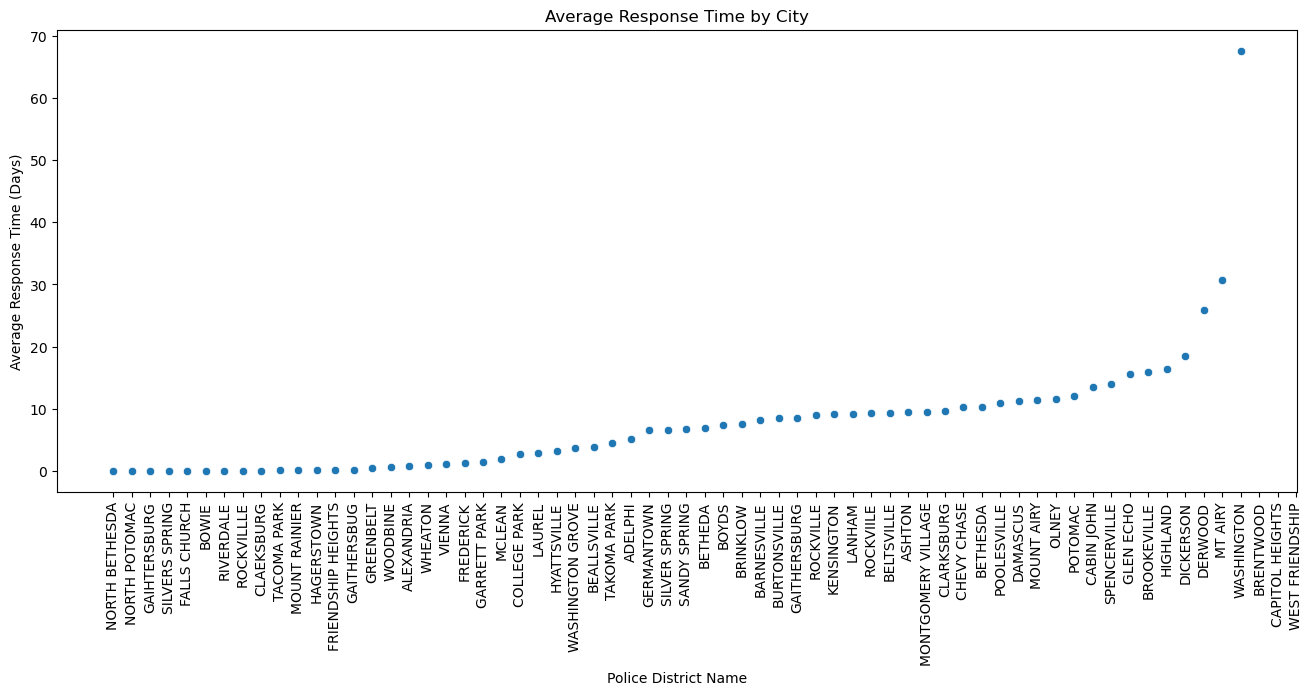

In [190]:
# Create the scatter plot using seaborn
plt.figure(figsize=(16, 6))
sns.scatterplot(x='City', y='Response_time_days', data=avg_response_times)

# Add a title and labels for the x-axis and y-axis
plt.title('Average Response Time by City')
plt.xlabel('Police District Name')
plt.ylabel('Average Response Time (Days)')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90, ha='center')

# Display the plot
plt.show()

Visualisation 2

In [215]:
# Calculate the average `Response_time_days` for each `City` and sort the values in descending order
avg_response_times = df_D.groupby('City')['Response_time_days'].mean().sort_values(ascending=False).reset_index()

# Select the top 10 cities with the highest response times
top_10_cities = avg_response_times.head(10)

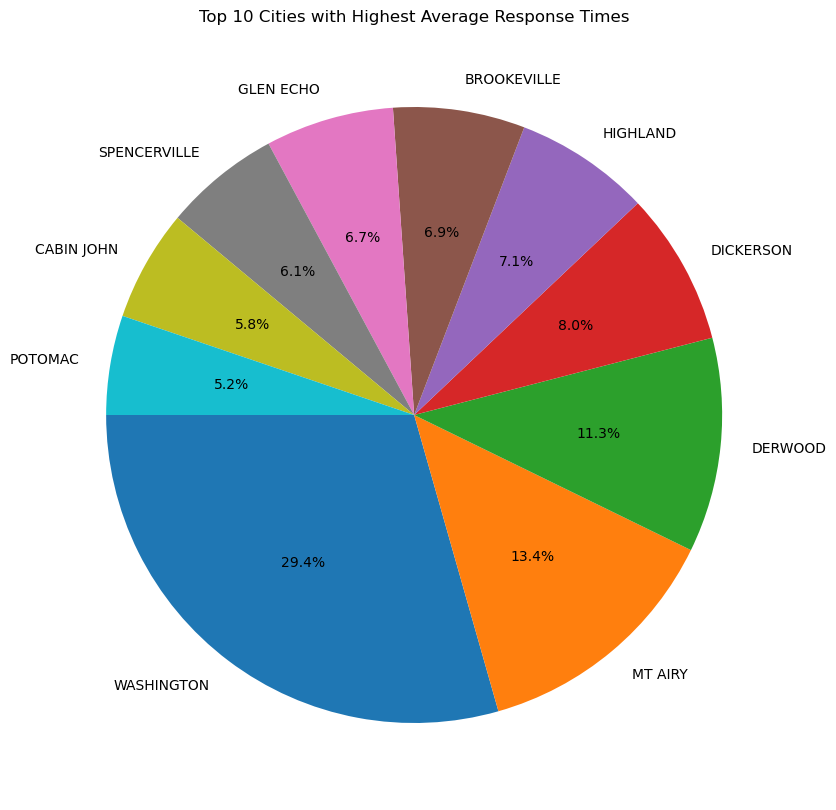

In [217]:
# Create the pie chart using matplotlib
plt.figure(figsize=(12, 10))
plt.pie(top_10_cities['Response_time_days'], labels=top_10_cities['City'], autopct='%1.1f%%', startangle=180)
plt.title('Top 10 Cities with Highest Average Response Times')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_24712\2982035990.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(x='City', y='Response_time_days', data=top_10_cities, palette='plasma')


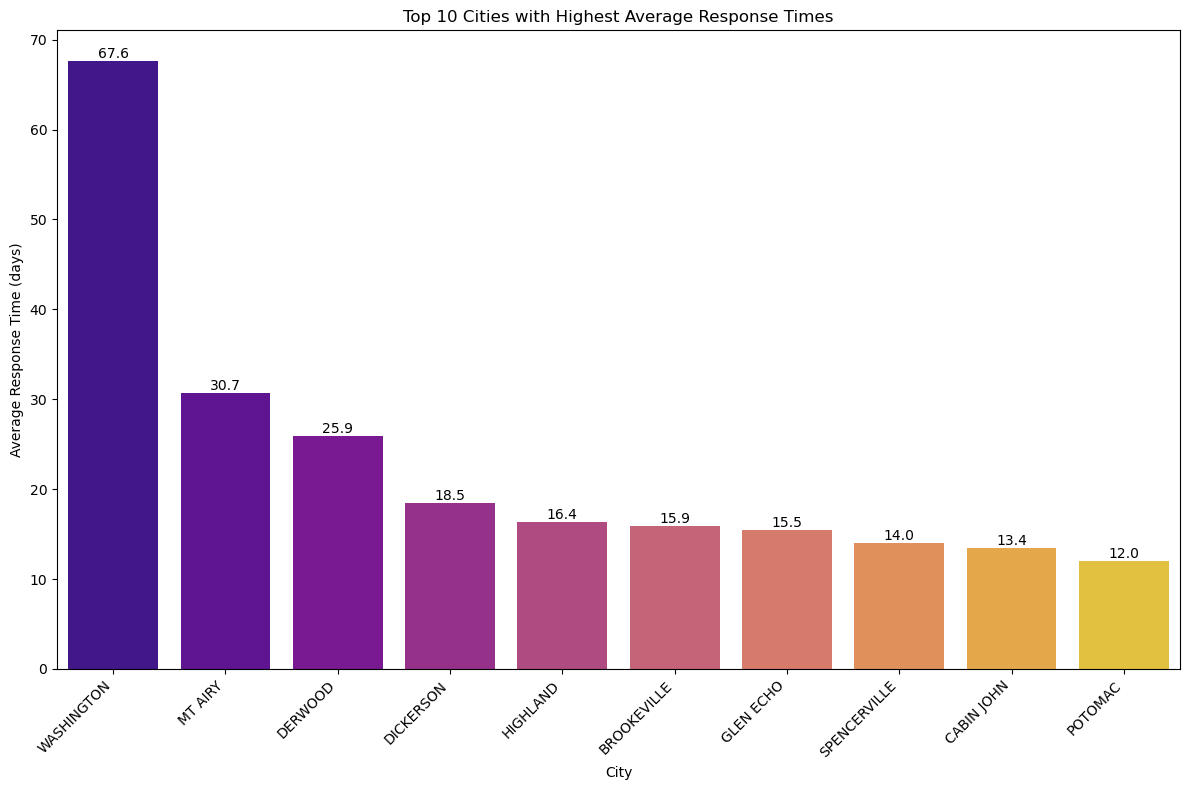

In [517]:
# Create the bar plot using seaborn
plt.figure(figsize=(12, 8))
ax=sns.barplot(x='City', y='Response_time_days', data=top_10_cities, palette='plasma')
plt.title('Top 10 Cities with Highest Average Response Times')
plt.xlabel('City')
plt.ylabel('Average Response Time (days)')

# Add data labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')
    
# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

Scatter plot for the crimes in different cities

In [520]:
# Function to summarize crime data by city
def summarize_crime_data_by_city(data):
    # Group by City, summing the crime count, and taking the first latitude and longitude
    summary_df = data.groupby('City').agg(Number_of_Crimes=('City', 'size'), Latitude=('Latitude', 'first'), Longitude=('Longitude', 'first')).reset_index()
    summary_df = summary_df[(summary_df['Latitude'] != 0) & (summary_df['Longitude'] != 0)]
    return summary_df

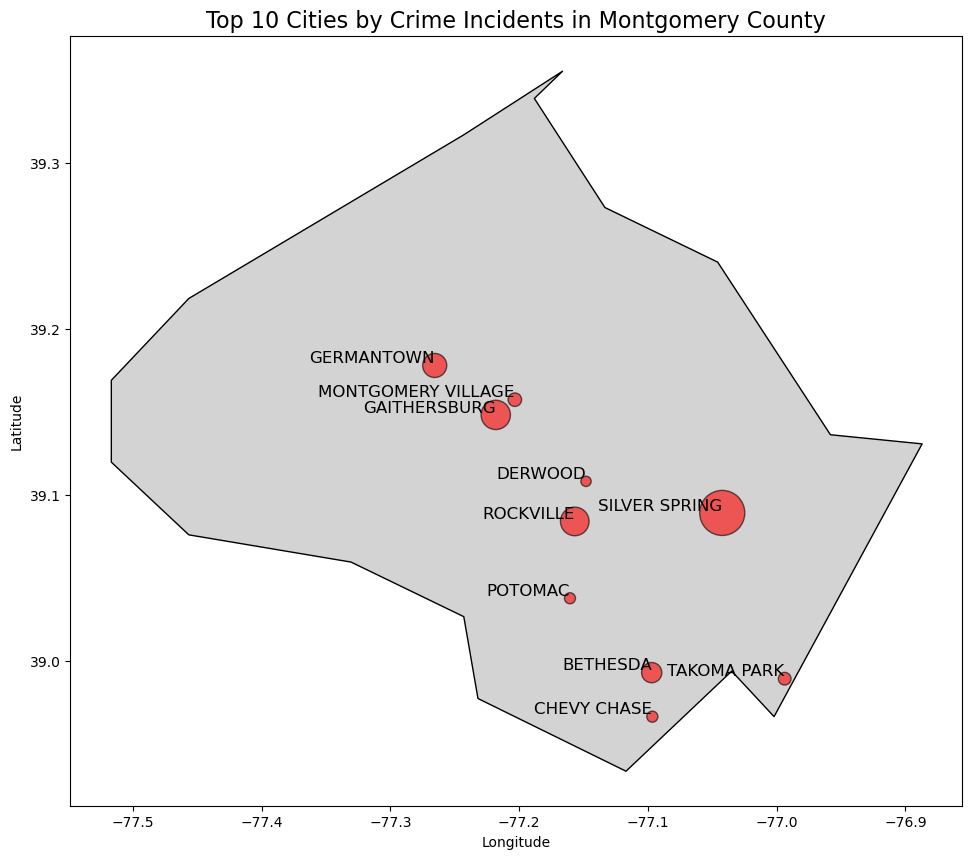

In [556]:
crime_summary_df = summarize_crime_data_by_city(df_D) #Calling the function above. 

# Filter to get the top 10 cities by crime count
top_cities_df = crime_summary_df.nlargest(10, 'Number_of_Crimes')

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 10))
plt.title("Top 10 Cities by Crime Incidents in Montgomery County", fontsize=16)

# Plot the GeoJSON data as the county background
county_map.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=1)

# Overlay scatter plot with top 10 cities crime data
scatter = ax.scatter(top_cities_df['Longitude'], top_cities_df['Latitude'], s=top_cities_df['Number_of_Crimes']/ 100,color='red', alpha=0.6, edgecolor="k", marker="o")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Annotation
for i, row in top_cities_df.iterrows():
    ax.text(
        row['Longitude'], row['Latitude'], 
        row['City'], fontsize=12, ha='right', va='bottom', color='black'
    )

plt.show()

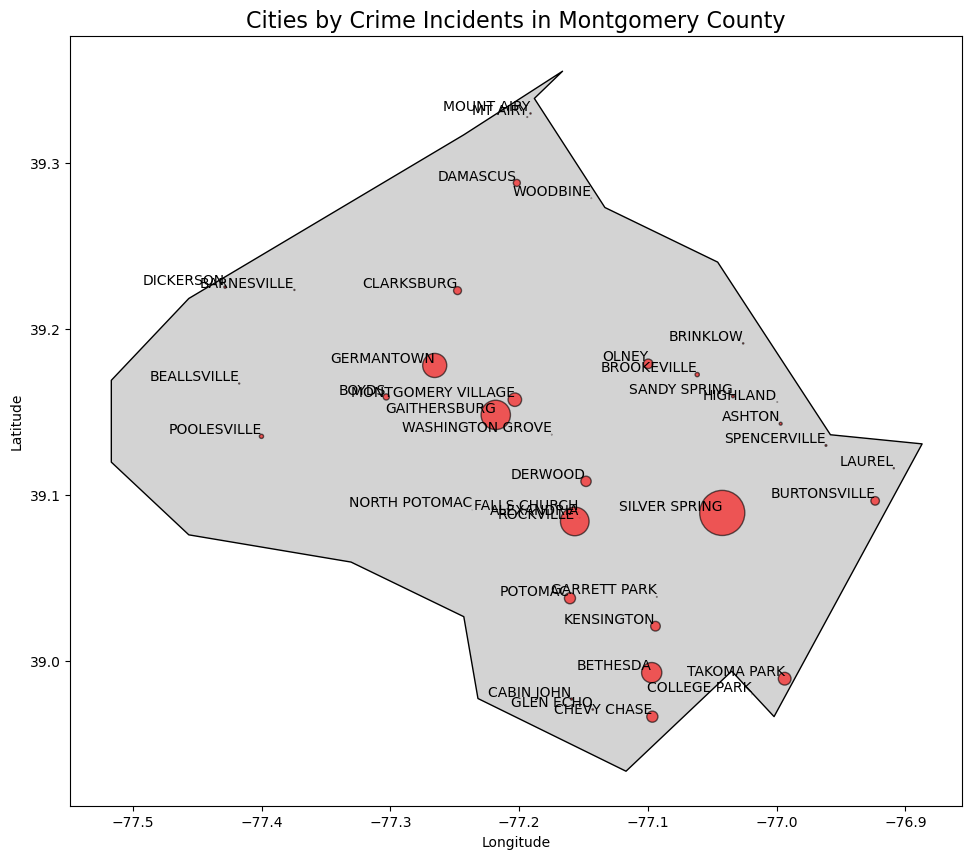

In [562]:
crime_summary_df = summarize_crime_data_by_city(df_D) #Calling the function above. 

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 10))
plt.title("Cities by Crime Incidents in Montgomery County", fontsize=16)

# Plot the GeoJSON data as the county background
county_map.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=1)

# Overlay scatter plot with top 10 cities crime data
scatter = ax.scatter(crime_summary_df['Longitude'], crime_summary_df['Latitude'], s=crime_summary_df['Number_of_Crimes']/ 100,color='red', alpha=0.6, edgecolor="k", marker="o")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Annotation
for i, row in crime_summary_df.iterrows():
    ax.text(
        row['Longitude'], row['Latitude'], 
        row['City'], fontsize=10, ha='right', va='bottom', color='black'
    )

plt.show()